### Earthquake Modeling

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import shap

warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'catboost'

#### 1. Load the cleaned data

In [2]:
earthquakes = pd.read_csv('master_df.csv')
print(earthquakes.shape)

earthquakes_reduced = pd.read_csv('master_df_reduced.csv')
print(earthquakes_reduced.shape)

earthquakes_reg_pop = pd.read_csv('master_df_regional_pop.csv')
print(earthquakes_reg_pop.shape)


(1030, 44)
(1030, 11)
(1030, 49)


#### 2. Explore Dataset and Missing Values

In [3]:
earthquakes_reg_pop.head()

,Unnamed: 0,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Country,...,Total Houses Damaged Description,Total Houses Damaged Description.1,Region,Average Income,p0p50_share,Population density national,preperation_zone,pop_with_water,pop_without_water,pop_total
0,0,2000,1,11,23.0,43.0,56.4,NaN,NaN,CHINA,...,4.0,4.0,LIAONING PROVINCE,4836.4401,0.1737,134.647500,164.9,196.047281,248.925429,2.089903e+07
1,1,2000,1,14,23.0,37.0,7.8,NaN,NaN,CHINA,...,NaN,NaN,YAOAN COUNTY,4836.4401,0.1737,134.647500,356.1,75.744613,76.155580,3.829049e+07
2,2,2000,6,7,21.0,46.0,55.9,NaN,NaN,CHINA,...,NaN,NaN,LIUKU; MYANMAR,4836.4401,0.1737,134.647500,572.6,36.681915,38.318019,4.788112e+07
3,3,2000,8,21,13.0,25.0,44.5,NaN,NaN,CHINA,...,NaN,NaN,WUDING,4836.4401,0.1737,134.647500,70.2,67.648044,67.648044,1.307028e+06
4,4,2000,2,2,22.0,58.0,1.5,NaN,NaN,IRAN,...,3.0,3.0,KASHMAR,13549.8134,0.1232,40.397152,212.7,30.027525,30.027525,5.372795e+06


In [4]:
earthquakes_reg_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1030 non-null   int64  
 1   Year                                1030 non-null   int64  
 2   Mo                                  1030 non-null   int64  
 3   Dy                                  1030 non-null   int64  
 4   Hr                                  1030 non-null   float64
 5   Mn                                  1030 non-null   float64
 6   Sec                                 1024 non-null   float64
 7   Tsu                                 168 non-null    float64
 8   Vol                                 7 non-null      float64
 9   Country                             1030 non-null   object 
 10  Location Name                       1030 non-null   object 
 11  Latitude                            1030 no

Counting Missing values on the dataset

In [5]:
df = earthquakes_reg_pop.copy()
# number and percentage of missing values according to columns
{col: [df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}'
      ] for col in df.columns if df[col].isnull().any()}

{'Sec': [6, '% 0.583'],
 'Tsu': [862, '% 83.689'],
 'Vol': [1023, '% 99.32'],
 'Focal Depth (km)': [11, '% 1.068'],
 'Mag': [3, '% 0.291'],
 'MMI Int': [720, '% 69.903'],
 'Deaths': [576, '% 55.922'],
 'Death Description': [574, '% 55.728'],
 'Missing': [1015, '% 98.544'],
 'Missing Description': [1016, '% 98.641'],
 'Injuries': [432, '% 41.942'],
 'Injuries Description': [390, '% 37.864'],
 'Damage ($Mil)': [878, '% 85.243'],
 'Damage Description': [150, '% 14.563'],
 'Houses Destroyed': [734, '% 71.262'],
 'Houses Destroyed Description': [603, '% 58.544'],
 'Houses Damaged': [710, '% 68.932'],
 'Houses Damaged Description': [509, '% 49.417'],
 'Total Deaths': [568, '% 55.146'],
 'Total Death Description': [568, '% 55.146'],
 'Total Missing': [1015, '% 98.544'],
 'Total Missing Description': [1013, '% 98.35'],
 'Total Injuries': [426, '% 41.359'],
 'Total Injuries Description': [384, '% 37.282'],
 'Total Damage ($Mil)': [873, '% 84.757'],
 'Total Damage Description': [148, '% 14.369']

<Axes: >

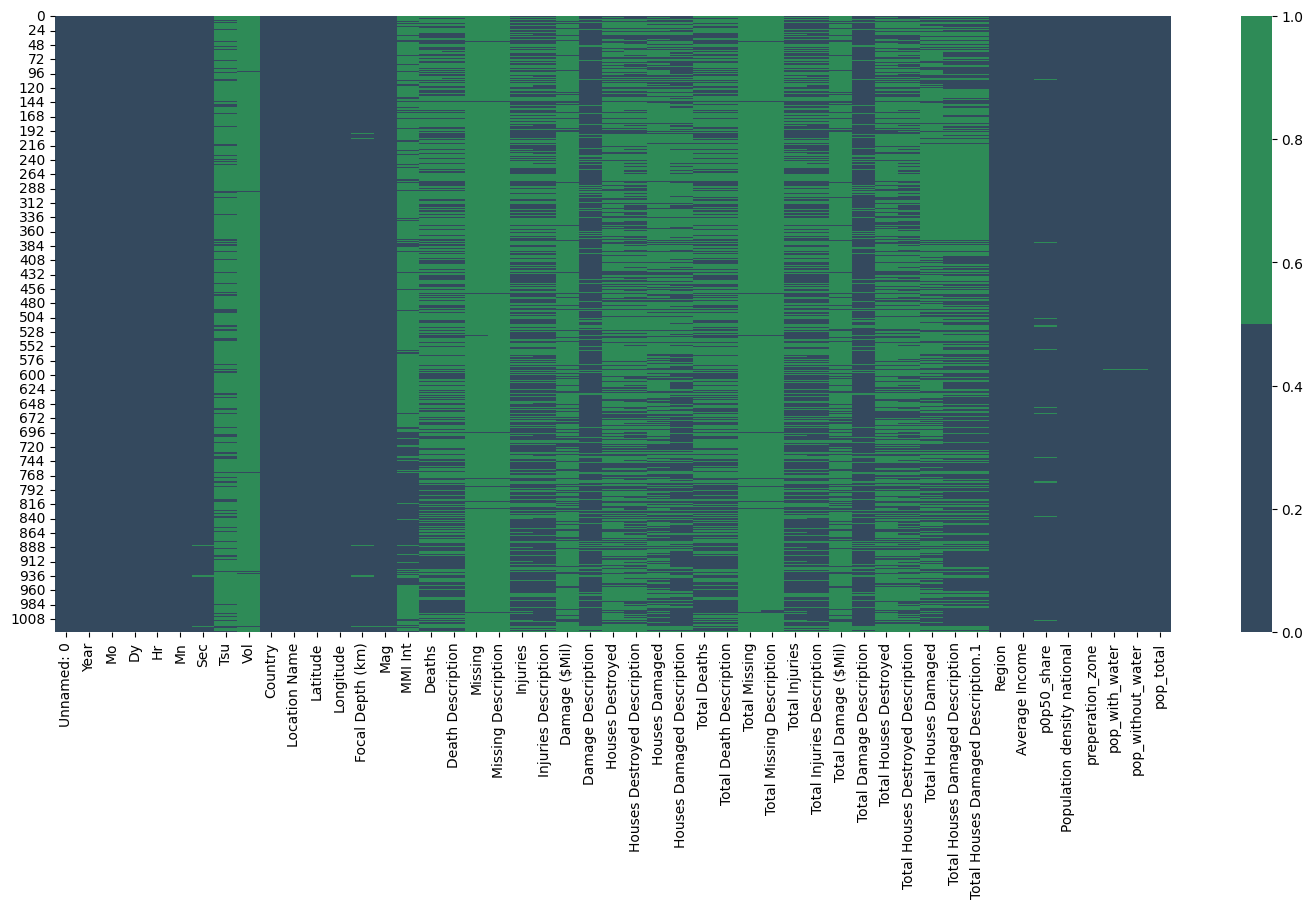

In [6]:
plt.figure(figsize=(18,8))

colours = ['#34495E', 'seagreen'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

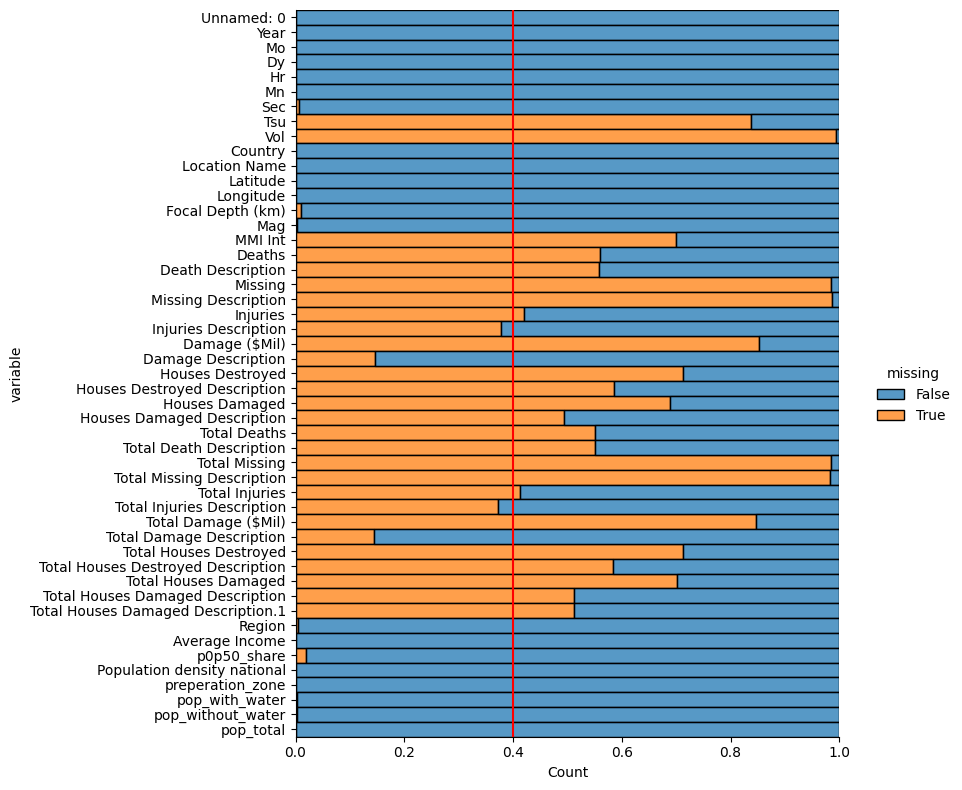

In [7]:
sns.displot(
    data=df.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
    aspect=1.1
)

# specifying a threshold value
plt.axvline(0.4, color='r')


#### 3.Modeling

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

b) CatBoost boosted trees

c) Random Forest

d) Extremely Randomized Trees

e) k- Nearest Neighbours

3.1 Split numerical and categorical variables

We define "Total Damage Description" as the Target Variable that ranges between 1 to 4 and that is associate to the degree of damage of each Earthquake. As it normally can be treated as a Target Categorical variable, we prefer to use it as a discrete continuos variable due to the fact that there is a lot of missing values in the datasets. 

In [8]:
num_df = df.select_dtypes(include='number')
cat_df = df.select_dtypes(exclude='number')

3.2. Impute Numerical values with KNN Imputer method

In [9]:

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

X = num_df.drop('Total Damage Description', axis=1)
y = num_df['Total Damage Description']

# Use KNNImputer to fill NaN values in 'y'
y = imputer.fit_transform(y.values.reshape(-1,1))

# Now 'y' is a 2D array, reshape it to 1D
y = y.reshape(-1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


3.3 Train and Test Ensambles and Tree-based Regressor Models

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

In [10]:
# Train the model
est = HistGradientBoostingRegressor().fit(x_train, y_train)

predictions = est.predict(x_test)

print("R2:",est.score(x_test, y_test))
print("MSE:",mean_squared_error(y_test, predictions))


R2: 0.9777240615375286
MSE: 0.02231729123077595


b) CatBoost boosted trees

In [11]:

# Train the model
est_catboost = CatBoostRegressor().fit(x_train, y_train)

predictions_catboost = est_catboost.predict(x_test)

print("R2:", est_catboost.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_catboost))


Learning rate set to 0.038612
0:	learn: 0.9876350	total: 58.5ms	remaining: 58.4s
1:	learn: 0.9627075	total: 59.3ms	remaining: 29.6s
2:	learn: 0.9397252	total: 59.9ms	remaining: 19.9s
3:	learn: 0.9173234	total: 60.6ms	remaining: 15.1s
4:	learn: 0.8961739	total: 61.3ms	remaining: 12.2s
5:	learn: 0.8750262	total: 62ms	remaining: 10.3s
6:	learn: 0.8515751	total: 62.5ms	remaining: 8.87s
7:	learn: 0.8296358	total: 63.2ms	remaining: 7.84s
8:	learn: 0.8109649	total: 64.1ms	remaining: 7.05s
9:	learn: 0.7896627	total: 64.6ms	remaining: 6.4s
10:	learn: 0.7692353	total: 65.4ms	remaining: 5.88s
11:	learn: 0.7519613	total: 66.2ms	remaining: 5.45s
12:	learn: 0.7276693	total: 66.9ms	remaining: 5.08s
13:	learn: 0.7120107	total: 67.5ms	remaining: 4.75s
14:	learn: 0.6960859	total: 68.3ms	remaining: 4.48s
15:	learn: 0.6751266	total: 69.1ms	remaining: 4.25s
16:	learn: 0.6618588	total: 69.7ms	remaining: 4.03s
17:	learn: 0.6399130	total: 70.4ms	remaining: 3.84s
18:	learn: 0.6230177	total: 71ms	remaining: 3.6

c) Random Forest

In [12]:

# Train the model
est_randomforest = RandomForestRegressor().fit(x_train, y_train)

predictions_randomforest = est_randomforest.predict(x_test)

print("R2:", est_randomforest.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_randomforest))


R2: 0.9796906763558935
MSE: 0.020347025613722418


d) Extremely Randomized Trees

In [13]:
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

X = num_df.drop('Total Damage Description', axis=1)
y = num_df['Total Damage Description']

# Use KNNImputer to fill NaN values in 'y'
y = imputer.fit_transform(y.values.reshape(-1,1))
X = imputer.fit_transform(X)

# Now 'y' is a 2D array, reshape it to 1D
y = y.reshape(-1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the model
est_extratrees = ExtraTreesRegressor().fit(x_train, y_train)

predictions_extratrees = est_extratrees.predict(x_test)

print("R2:", est_extratrees.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_extratrees))

R2: 0.9649075530902181
MSE: 0.03515759208105009


e) K- Nearest Neigbours

In [14]:
# Train the model
est_knn = KNeighborsRegressor().fit(x_train, y_train)

predictions_knn = est_knn.predict(x_test)

print("R2:", est_knn.score(x_test, y_test))
print("MSE:", mean_squared_error(y_test, predictions_knn))


R2: 0.023959381658442025
MSE: 0.9778525277079844


3.4 Model Comparision

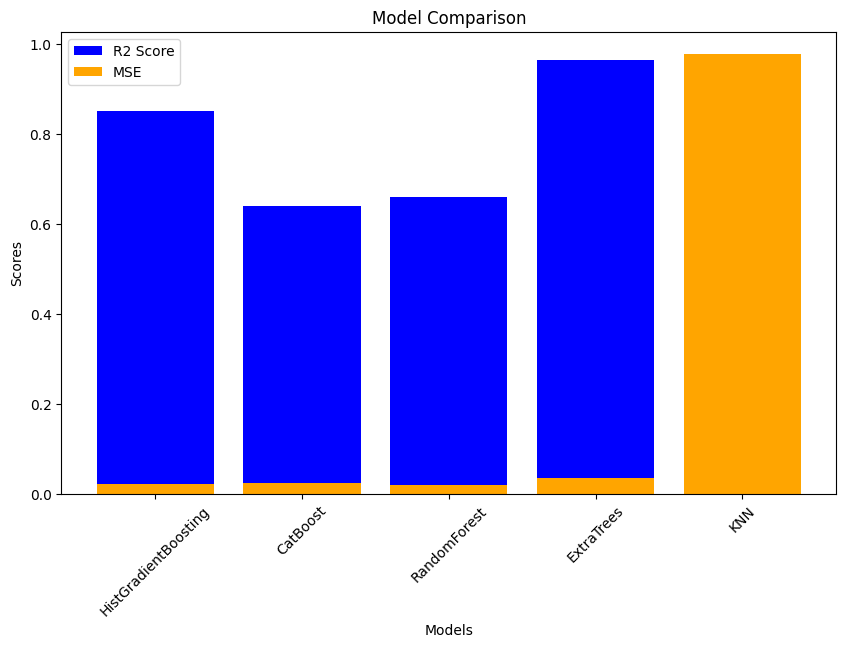

In [15]:
# Define the model names and corresponding scores
model_names = ['HistGradientBoosting', 'CatBoost', 'RandomForest', 'ExtraTrees', 'KNN']
r2_scores = [est.score(x_test, y_test), est_catboost.score(x_test, y_test), est_randomforest.score(x_test, y_test), est_extratrees.score(x_test, y_test), est_knn.score(x_test, y_test)]
mse_values = [mean_squared_error(y_test, predictions), mean_squared_error(y_test, predictions_catboost), mean_squared_error(y_test, predictions_randomforest), mean_squared_error(y_test, predictions_extratrees), mean_squared_error(y_test, predictions_knn)]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores, color='blue', label='R2 Score')
plt.bar(model_names, mse_values, color='orange', label='MSE')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)

plt.show()